In [6]:
import cooler
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns



In [20]:
###找marker基因的位置

# 指定需要查找的基因列表
genes_of_interest = ["OLIG1", "OLIG2", "SOX2", "SOX8", "ASCL1", "POU3F3", "HES6", "POU3F2"]

# 指定文件的绝对路径
file_path = '/cluster/home/jialu/genome/gencode.v38.pcg.dedup.tss.bed'

# 打开BED文件进行读取
with open(file_path, 'r') as file:
    for line in file:
        # 去除行尾的换行符并分割行
        fields = line.strip().split()
        
        # 检查行是否有足够的列
        if len(fields) >= 4:
            # 获取第四列，即基因名
            gene_name = fields[3]
            
            # 检查基因名是否在列表中
            if gene_name in genes_of_interest:
                # 打印或保存该行
                print(line.strip())

chr2	104853286	104853287	POU3F3	protein_coding
chr2	238240661	238240662	HES6	protein_coding
chr3	181711924	181711925	SOX2	protein_coding
chr6	98834573	98834574	POU3F2	protein_coding
chr12	102957673	102957674	ASCL1	protein_coding
chr16	981769	981770	SOX8	protein_coding
chr21	33025934	33025935	OLIG2	protein_coding
chr21	33070140	33070141	OLIG1	protein_coding


In [63]:
# 指定 .cooler 文件的路径
file_path = '/cluster/home/tmp/GBM/HiC/02data/03cool/1000000/norm/A172_normalized.cool'  # 替换为你的 .cooler 文件路径

# 加载 .cooler 文件
clr = cooler.Cooler(file_path)
clr.bins()[:3]


,chrom,start,end
0,chr1,0,1000000
1,chr1,1000000,2000000
2,chr1,2000000,3000000


In [59]:
import cooler

# 第一个cooler文件的路径
file_path = '/cluster/home/tmp/GBM/HiC/02data/03cool/5000/A172_5000.cool'
# 加载第一个cooler文件
clr = cooler.Cooler(file_path)
# 获取bins表的前200行切片范围
bins_slice = clr.bins()[:200]
# 筛选出weight列中非NaN的行，并获取前3行
non_nan_bins_slice = bins_slice[bins_slice['weight'].notna()].head(3)
# 打印第一个cooler文件的结果
print("第一个cooler文件中weight列非NaN的前3行:")
print(non_nan_bins_slice)

# 第二个cooler文件的路径
file_path1 = '/cluster/home/tmp/GBM/HiC/02data/03cool/5000/U87_5000.cool'
# 加载第二个cooler文件
clr1 = cooler.Cooler(file_path1)
# 获取bins表的前200行切片范围
bins_slice1 = clr1.bins()[:200]
# 筛选出weight列中非NaN的行，并获取前3行
non_nan_bins_slice1 = bins_slice1[bins_slice1['weight'].notna()].head(3)
# 打印第二个cooler文件的结果
print("\n第二个cooler文件中weight列非NaN的前3行:")
print(non_nan_bins_slice1)

第一个cooler文件中weight列非NaN的前3行:
    chrom   start     end    weight
164  chr1  820000  825000  0.163629
182  chr1  910000  915000  0.314564
198  chr1  990000  995000  0.292373

第二个cooler文件中weight列非NaN的前3行:
    chrom   start     end    weight
164  chr1  820000  825000  0.119698
177  chr1  885000  890000  0.221060
180  chr1  900000  905000  0.139295


In [5]:
# 指定norm文件夹的路径
norm_folder_path = "/cluster/home/tmp/GBM/HiC/02data/03cool/5000/norm"

# 获取norm文件夹下所有的.cool文件
cooler_files = [os.path.join(norm_folder_path, file) for file in os.listdir(norm_folder_path) if file.endswith('.cool')]

# 指定需要查找的基因列表
genes_of_interest = ["OLIG1", "OLIG2", "SOX2", "SOX8", "ASCL1", "POU3F3", "HES6", "POU3F2"]

# 指定BED文件的绝对路径
bed_file_path = '/cluster/home/jialu/genome/gencode.v38.pcg.dedup.tss.bed'

gene_regions = []
with open(bed_file_path, 'r') as file:
    for line in file:
        fields = line.strip().split()
        if len(fields) >= 4 and fields[3] in genes_of_interest:
            gene_regions.append(fields[:4])

# 用于保存结果的列表
results = []

# 遍历每个cooler文件
for file_path in cooler_files:
    # 加载cooler文件
    parts = file_path.split('/')
    filename = parts[-1].replace('_normalized.cool', '')  # 去除"_normalized.cool"后缀

    # 加载cooler文件
    clr = cooler.Cooler(file_path)
    
    # 遍历筛选出的基因区域
    for gene_region in gene_regions:
        chrom, start, end, gene_name = gene_region
        start = int(start)
        end = int(end)
        
        # 获取特定染色体的全部bins信息，并转换为DataFrame
        chromsome_bins = pd.DataFrame(clr.bins().fetch(chrom), columns=['chrom', 'start', 'end', 'weight'])

        # 检查基因是否在bins内
        def is_gene_in_bins(chrom, start, end, chromsome_bins):
            for index, row in chromsome_bins.iterrows():
                if chrom == row['chrom'] and start >= row['start'] and end <= row['end']:
                    # 返回True和整行数据
                    return True, row
            return False, None
        
        # 执行函数并获取结果
        in_bins, bin_info = is_gene_in_bins(chrom, start, end, chromsome_bins)
        
        # 保存结果
        if in_bins:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\t{bin_info['weight']}"
        else:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\tNOT_FOUND"
        results.append(result)

# 将所有结果写入到一个文件: gene_bins_results.txt
output_file = "/cluster/home/jialu/GBM/gene_bins_results.txt"
with open(output_file, 'w') as file:
    for result in results:
        file.write(result + "\n")

print("结果已写入到", output_file)

结果已写入到 /cluster/home/jialu/GBM/gene_bins_results.txt


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

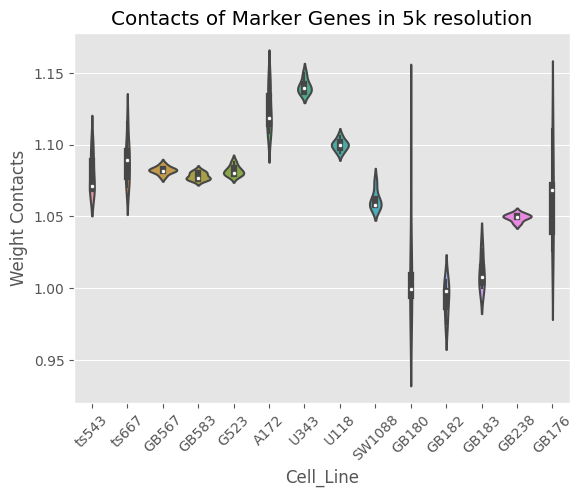

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight Contacts']
#df['Weight Contacts'] = df['Weight Contacts'].replace('nan', 0)  # 替换'nan'为0

# 设置绘图风格
plt.style.use('ggplot')

# 绘制分组小提琴图
sns.violinplot(x="Cell_Line", y="Weight Contacts", data=df,order = ['ts543','ts667','G567','G583','G523','A172','U343','U118','SW1088','GB180','GB182','GB183','GB238','GB176'],)

# 添加图形标题
plt.title('Contacts of Marker Genes in 5k resolution')

# 倾斜x轴标签
plt.xticks(rotation=45)  # 将x轴标签旋转45度

# 显示图形
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

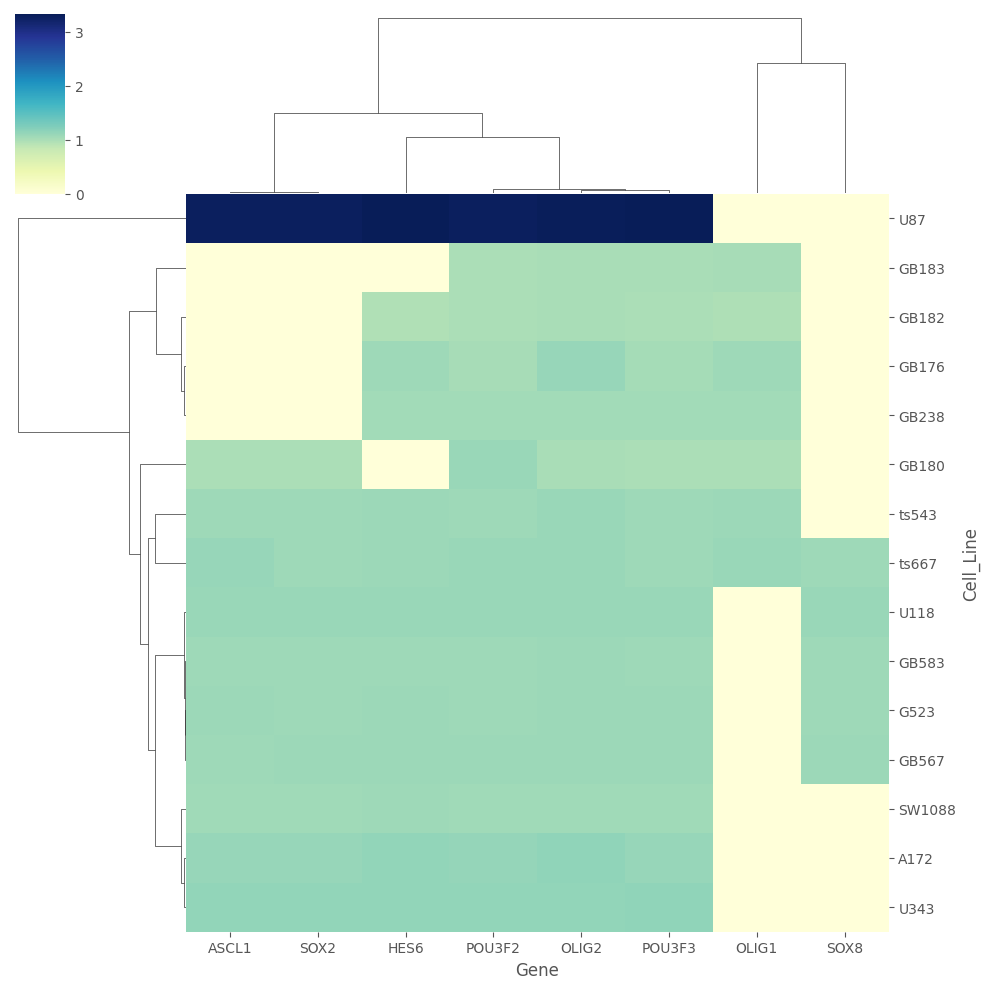

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取CSV文件并设置列名
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight_Contacts']

# 确保'Weight_Contacts'列是数值类型
df['Weight_Contacts'] = pd.to_numeric(df['Weight_Contacts'], errors='coerce')

# 使用pivot方法创建一个新的DataFrame，其中'Cell_Line'是行索引，'Gene'是列索引，'Weight_Contacts'是数值
df_pivot = df.pivot_table(index='Cell_Line', columns='Gene', values='Weight_Contacts', fill_value=0)

# 使用seaborn的heatmap函数绘制热图，并标注原始数值
g = sns.clustermap(df_pivot, fmt='d', cmap='YlGnBu')
ax = g.ax_heatmap
label_y = ax.get_yticklabels()
plt.setp(label_y,rotation=360, horizontalalignment='left')
plt.show()

In [26]:
# 指定norm文件夹的路径
norm_folder_path = "/cluster/home/tmp/GBM/HiC/02data/03cool/5000/0_1norm"

# 获取norm文件夹下所有的.cool文件
cooler_files = [os.path.join(norm_folder_path, file) for file in os.listdir(norm_folder_path) if file.endswith('.cool')]

# 指定需要查找的基因列表
genes_of_interest = ["OLIG1", "OLIG2", "SOX2", "SOX8", "ASCL1", "POU3F3", "HES6", "POU3F2"]

# 指定BED文件的绝对路径
bed_file_path = '/cluster/home/jialu/genome/gencode.v38.pcg.dedup.tss.bed'

gene_regions = []
with open(bed_file_path, 'r') as file:
    for line in file:
        fields = line.strip().split()
        if len(fields) >= 4 and fields[3] in genes_of_interest:
            gene_regions.append(fields[:4])

# 用于保存结果的列表
results = []

# 遍历每个cooler文件
for file_path in cooler_files:
    # 加载cooler文件
    parts = file_path.split('/')
    filename = parts[-1].replace('_5000_0_1_range.cool', '')  # 去除"_normalized.cool"后缀

    # 加载cooler文件
    clr = cooler.Cooler(file_path)
    
    # 遍历筛选出的基因区域
    for gene_region in gene_regions:
        chrom, start, end, gene_name = gene_region
        start = int(start)
        end = int(end)
        
        # 获取特定染色体的全部bins信息，并转换为DataFrame
        chromsome_bins = pd.DataFrame(clr.bins().fetch(chrom), columns=['chrom', 'start', 'end', 'weight'])

        # 检查基因是否在bins内
        def is_gene_in_bins(chrom, start, end, chromsome_bins):
            for index, row in chromsome_bins.iterrows():
                if chrom == row['chrom'] and start >= row['start'] and end <= row['end']:
                    # 返回True和整行数据
                    return True, row
            return False, None
        
        # 执行函数并获取结果
        in_bins, bin_info = is_gene_in_bins(chrom, start, end, chromsome_bins)
        
        # 保存结果
        if in_bins:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\t{bin_info['weight']}"
        else:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\tNOT_FOUND"
        results.append(result)

# 将所有结果写入到一个文件: gene_bins_results.txt
output_file = "/cluster/home/jialu/GBM/gene_bins_results_0_1.txt"
with open(output_file, 'w') as file:
    for result in results:
        file.write(result + "\n")

print("结果已写入到", output_file)

结果已写入到 /cluster/home/jialu/GBM/gene_bins_results_0_1.txt


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

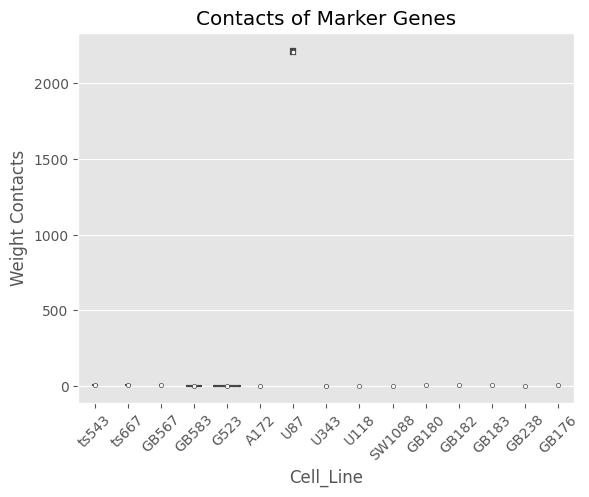

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results_0_1.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight Contacts']
#df['Weight Contacts'] = df['Weight Contacts'].replace('nan', 0)  # 替换'nan'为0

# 设置绘图风格
plt.style.use('ggplot')

# 绘制分组小提琴图
sns.violinplot(x="Cell_Line", y="Weight Contacts", data=df,order = ['ts543','ts667','G567','G583','G523','A172','U87','U343','U118','SW1088','GB180','GB182','GB183','GB238','GB176'],)

# 添加图形标题
plt.title('Contacts of Marker Genes')

# 倾斜x轴标签
plt.xticks(rotation=45)  # 将x轴标签旋转45度

# 显示图形
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

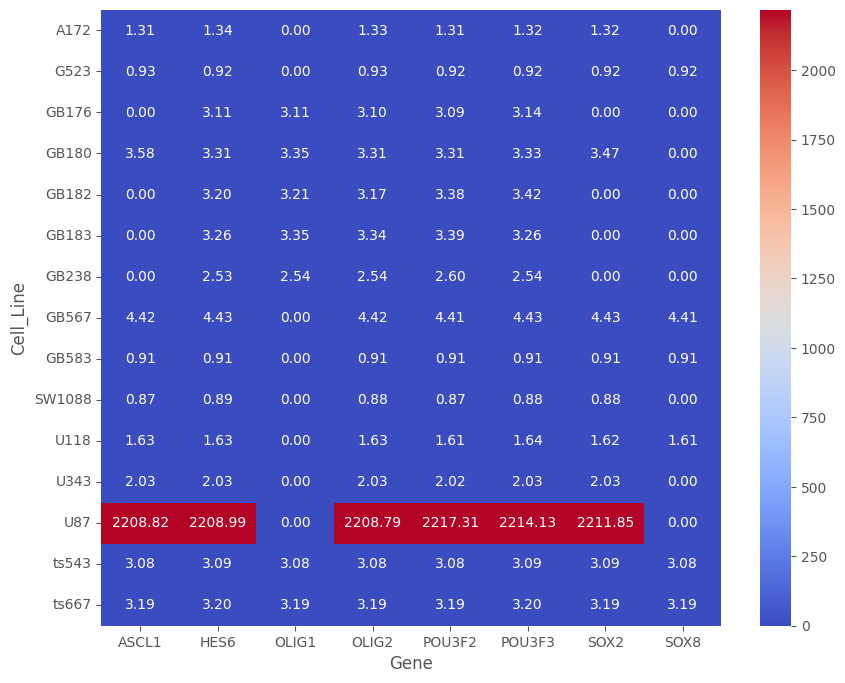

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取CSV文件并设置列名
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results_0_1.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight_Contacts']

# 确保'Weight_Contacts'列是数值类型
df['Weight_Contacts'] = pd.to_numeric(df['Weight_Contacts'], errors='coerce')

# 使用pivot方法创建一个新的DataFrame，其中'Cell_Line'是行索引，'Gene'是列索引，'Weight_Contacts'是数值
df_pivot = df.pivot_table(index='Cell_Line', columns='Gene', values='Weight_Contacts', fill_value=0)

# 使用seaborn的heatmap函数绘制热图，并标注原始数值
plt.figure(figsize=(10, 8))  # 可以根据需要调整图形大小
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# 显示图形
plt.show()

In [64]:
# 指定norm文件夹的路径
norm_folder_path = "/cluster/home/tmp/GBM/HiC/02data/03cool/1000000/norm"

# 获取norm文件夹下所有的.cool文件
cooler_files = [os.path.join(norm_folder_path, file) for file in os.listdir(norm_folder_path) if file.endswith('.cool')]

# 指定需要查找的基因列表
genes_of_interest = ["OLIG1", "OLIG2", "SOX2", "SOX8", "ASCL1", "POU3F3", "HES6", "POU3F2"]

# 指定BED文件的绝对路径
bed_file_path = '/cluster/home/jialu/genome/gencode.v38.pcg.dedup.tss.bed'

gene_regions = []
with open(bed_file_path, 'r') as file:
    for line in file:
        fields = line.strip().split()
        if len(fields) >= 4 and fields[3] in genes_of_interest:
            gene_regions.append(fields[:4])

# 用于保存结果的列表
results = []

# 遍历每个cooler文件
for file_path in cooler_files:
    # 加载cooler文件
    parts = file_path.split('/')
    filename = parts[-1].replace('_normalized.cool', '')  # 去除"_normalized.cool"后缀

    # 加载cooler文件
    clr = cooler.Cooler(file_path)
    
    # 遍历筛选出的基因区域
    for gene_region in gene_regions:
        chrom, start, end, gene_name = gene_region
        start = int(start)
        end = int(end)
        
        # 获取特定染色体的全部bins信息，并转换为DataFrame
        chromsome_bins = pd.DataFrame(clr.bins().fetch(chrom), columns=['chrom', 'start', 'end', 'weight'])

        # 检查基因是否在bins内
        def is_gene_in_bins(chrom, start, end, chromsome_bins):
            for index, row in chromsome_bins.iterrows():
                if chrom == row['chrom'] and start >= row['start'] and end <= row['end']:
                    # 返回True和整行数据
                    return True, row
            return False, None
        
        # 执行函数并获取结果
        in_bins, bin_info = is_gene_in_bins(chrom, start, end, chromsome_bins)
        
        # 保存结果
        if in_bins:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\t{bin_info['weight']}"
        else:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\tNOT_FOUND"
        results.append(result)

# 将所有结果写入到一个文件: gene_bins_results.txt
output_file = "/cluster/home/jialu/GBM/gene_bins_results_1M.txt"
with open(output_file, 'w') as file:
    for result in results:
        file.write(result + "\n")

print("结果已写入到", output_file)

结果已写入到 /cluster/home/jialu/GBM/gene_bins_results_1M.txt


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

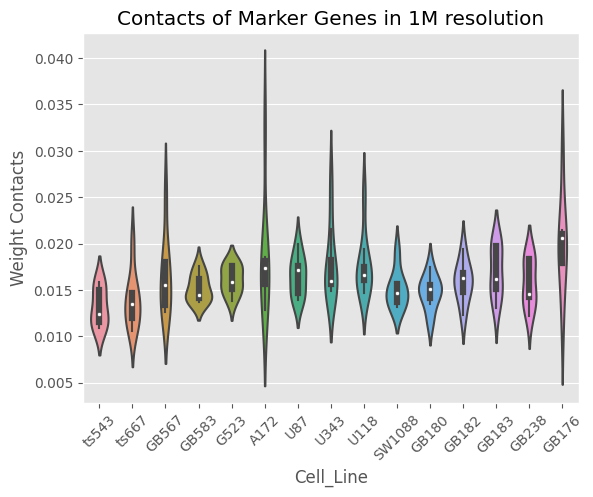

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results_1M.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight Contacts']
#df['Weight Contacts'] = df['Weight Contacts'].replace('nan', 0)  # 替换'nan'为0

# 设置绘图风格
plt.style.use('ggplot')

# 绘制分组小提琴图
sns.violinplot(x="Cell_Line", y="Weight Contacts", data=df,order = ['ts543','ts667','G567','G583','G523','A172','U87','U343','U118','SW1088','GB180','GB182','GB183','GB238','GB176'],)

# 添加图形标题
plt.title('Contacts of Marker Genes in 1M resolution')

# 倾斜x轴标签
plt.xticks(rotation=45)  # 将x轴标签旋转45度

# 显示图形
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

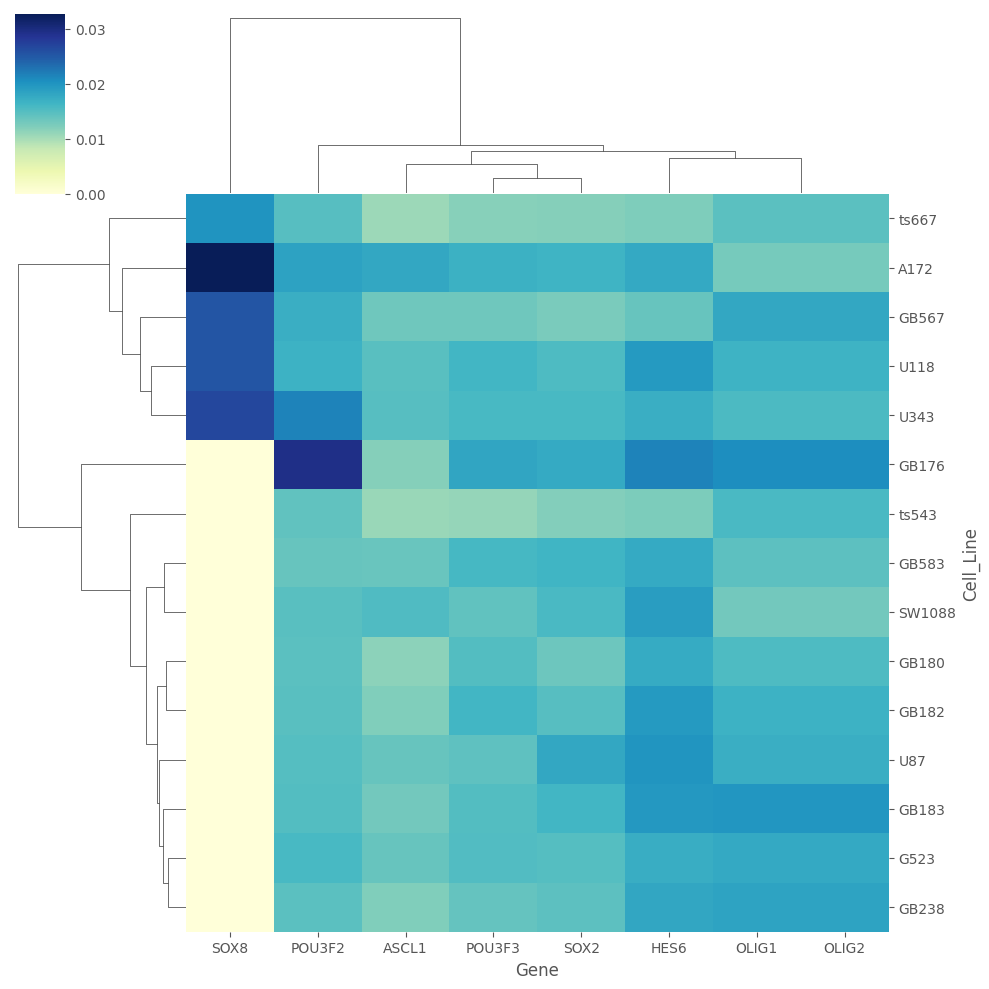

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取CSV文件并设置列名
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results_1M.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight_Contacts']

# 确保'Weight_Contacts'列是数值类型，并将非数值转换为NaN
df['Weight_Contacts'] = pd.to_numeric(df['Weight_Contacts'], errors='coerce')

# 使用pivot方法创建一个新的DataFrame
df_pivot = df.pivot_table(index='Cell_Line', columns='Gene', values='Weight_Contacts', fill_value=0)

# 使用seaborn的heatmap函数绘制热图，并保留三位小数

g = sns.clustermap(df_pivot, fmt='d', cmap='YlGnBu')
ax = g.ax_heatmap
label_y = ax.get_yticklabels()
plt.setp(label_y,rotation=360, horizontalalignment='left')
plt.show()



In [77]:
# 指定norm文件夹的路径
norm_folder_path = "/cluster/home/tmp/GBM/HiC/02data/03cool/100000/norm"

# 获取norm文件夹下所有的.cool文件
cooler_files = [os.path.join(norm_folder_path, file) for file in os.listdir(norm_folder_path) if file.endswith('.cool')]

# 指定需要查找的基因列表
genes_of_interest = ["OLIG1", "OLIG2", "SOX2", "SOX8", "ASCL1", "POU3F3", "HES6", "POU3F2"]

# 指定BED文件的绝对路径
bed_file_path = '/cluster/home/jialu/genome/gencode.v38.pcg.dedup.tss.bed'

gene_regions = []
with open(bed_file_path, 'r') as file:
    for line in file:
        fields = line.strip().split()
        if len(fields) >= 4 and fields[3] in genes_of_interest:
            gene_regions.append(fields[:4])

# 用于保存结果的列表
results = []

# 遍历每个cooler文件
for file_path in cooler_files:
    # 加载cooler文件
    parts = file_path.split('/')
    filename = parts[-1].replace('_normalized.cool', '')  # 去除"_normalized.cool"后缀

    # 加载cooler文件
    clr = cooler.Cooler(file_path)
    
    # 遍历筛选出的基因区域
    for gene_region in gene_regions:
        chrom, start, end, gene_name = gene_region
        start = int(start)
        end = int(end)
        
        # 获取特定染色体的全部bins信息，并转换为DataFrame
        chromsome_bins = pd.DataFrame(clr.bins().fetch(chrom), columns=['chrom', 'start', 'end', 'weight'])

        # 检查基因是否在bins内
        def is_gene_in_bins(chrom, start, end, chromsome_bins):
            for index, row in chromsome_bins.iterrows():
                if chrom == row['chrom'] and start >= row['start'] and end <= row['end']:
                    # 返回True和整行数据
                    return True, row
            return False, None
        
        # 执行函数并获取结果
        in_bins, bin_info = is_gene_in_bins(chrom, start, end, chromsome_bins)
        
        # 保存结果
        if in_bins:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\t{bin_info['weight']}"
        else:
            result = f"{filename}\t{gene_name}\t{chrom}\t{start}\t{end}\tNOT_FOUND"
        results.append(result)

# 将所有结果写入到一个文件: gene_bins_results.txt
output_file = "/cluster/home/jialu/GBM/gene_bins_results_100k.txt"
with open(output_file, 'w') as file:
    for result in results:
        file.write(result + "\n")

print("结果已写入到", output_file)

结果已写入到 /cluster/home/jialu/GBM/gene_bins_results_100k.txt


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

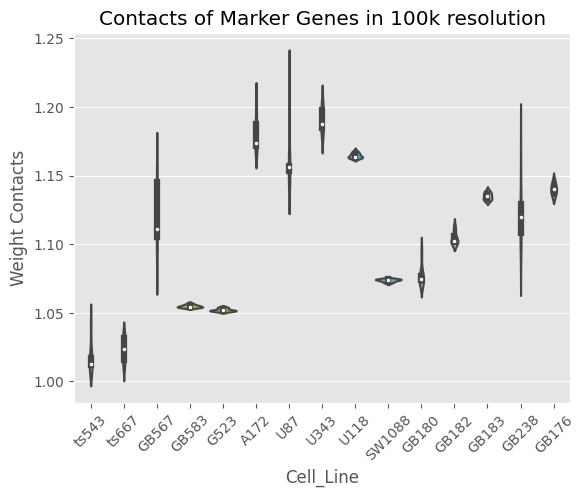

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results_100k.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight Contacts']
#df['Weight Contacts'] = df['Weight Contacts'].replace('nan', 0)  # 替换'nan'为0

# 设置绘图风格
plt.style.use('ggplot')

# 绘制分组小提琴图
sns.violinplot(x="Cell_Line", y="Weight Contacts", data=df,order = ['ts543','ts667','G567','G583','G523','A172','U87','U343','U118','SW1088','GB180','GB182','GB183','GB238','GB176'],)

# 添加图形标题
plt.title('Contacts of Marker Genes in 100k resolution')

# 倾斜x轴标签
plt.xticks(rotation=45)  # 将x轴标签旋转45度

# 显示图形
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

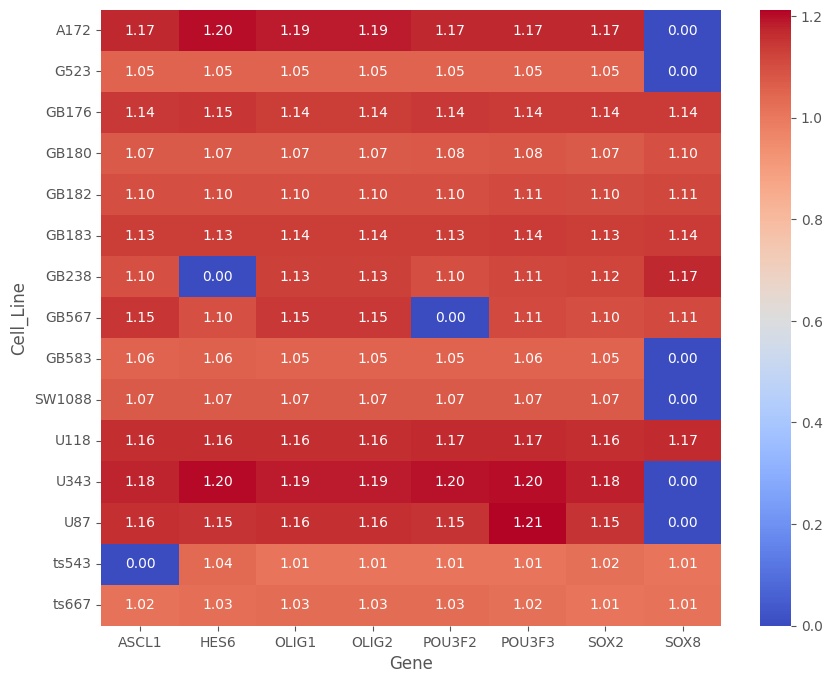

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取CSV文件并设置列名
df = pd.read_csv('/cluster/home/jialu/GBM/gene_bins_results_100k.txt', sep='\t', header=None)
df.columns = ['Cell_Line', 'Gene', 'Chromosome', 'Position_Start', 'Position_End', 'Weight_Contacts']

# 确保'Weight_Contacts'列是数值类型
df['Weight_Contacts'] = pd.to_numeric(df['Weight_Contacts'], errors='coerce')

# 使用pivot方法创建一个新的DataFrame，其中'Cell_Line'是行索引，'Gene'是列索引，'Weight_Contacts'是数值
df_pivot = df.pivot_table(index='Cell_Line', columns='Gene', values='Weight_Contacts', fill_value=0)

# 使用seaborn的heatmap函数绘制热图，并标注原始数值
plt.figure(figsize=(10, 8))  # 可以根据需要调整图形大小
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# 显示图形
plt.show()